In [1]:
import pandas as pd 
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pymysql
config = {
    'host': '192.168.1.31',
    'port': 4000,
    'user': 'liyufan',
    'passwd': 'liyufan@2020',
    'charset':'utf8mb4',
    'cursorclass':pymysql.cursors.DictCursor
    }
conn = pymysql.connect(**config)

In [55]:
worktime = pd.read_csv('_SELECT_e_DeliveryTime_e_PickEmpName_ShelfAreaName_sumPickQty_sk_202105051727.csv')

In [71]:
worktime.head()

,DeliveryTime,PickEmpName,ShelfAreaName,sumPickQty,sku_count,sum_resttime,worktime,actual_worktime
0,2020-11-02,丁小顺,生鲜9组,1329.0,16,1744,13817,12073
1,2020-11-03,丁小顺,生鲜9组,1553.0,14,1738,15071,13333
2,2020-11-04,丁小顺,生鲜9组,1108.0,14,1236,14525,13289
3,2020-11-05,丁小顺,生鲜9组,1795.0,16,1617,15436,13819
4,2020-11-08,丁小顺,生鲜9组,1557.0,16,1834,14499,12665


In [57]:
worktime['DeliveryTime']=pd.to_datetime(worktime['DeliveryTime']).dt.normalize()

In [58]:
picking_product = pd.read_csv('pick_product.csv')

In [59]:
def list_str_to_float(name): 
    return list(map(float,name))

In [60]:
def getWeight(product_name, sale_unit_qty, sale_stock_qty):
    weight = 0
    product_name = product_name.split(' 适合')[0]
    productList = product_name.split(' ')

    for pName in productList:
        if 'kg' in pName:
            reg = re.findall(r'\d+\.?\d*(?=kg)', pName)
            if len(reg) > 0:
                reg = list_str_to_float(reg)
                weight = float(np.max(reg)) * 2
        elif 'KG' in pName:
            reg = re.findall(r'\d+\.?\d*(?=kg)', pName)
            if len(reg) > 0:
                reg = list_str_to_float(reg)
                weight = float(np.max(reg)) * 2
        elif '斤' in pName:
            reg = re.findall(r'\d+\.?\d*(?=斤)', pName)
            if len(reg) > 0:
                reg = list_str_to_float(reg)
                weight = float(np.max(reg))
        elif '公斤' in pName:
            reg = re.findall(r'\d+\.?\d*(?=公斤)', pName)
            if len(reg) > 0:
                reg = list_str_to_float(reg)
                weight = float(np.max(reg)) * 2
        elif 'g' in pName:
            reg = re.findall(r'\d+\.?\d*(?=g)', pName)
            if len(reg) > 0:
                reg = list_str_to_float(reg)
                weight = float(np.max(reg)) / 500
        elif 'L' in pName:
            reg = re.findall(r'\d+\.?\d*(?=L)', pName)
            if len(reg) > 0:
                reg = list_str_to_float(reg)
                weight = float(np.max(reg)) * 2
        elif 'ml' in pName:
            reg = re.findall(r'\d+\.?\d*(?=ml)', pName)
            if len(reg) > 0:
                reg = list_str_to_float(reg)
                weight = float(np.max(reg)) / 500
        if weight>0:
            break
    weight = weight * sale_unit_qty * sale_stock_qty
    return weight

In [61]:
import re
picking_product['weight'] =picking_product.apply(lambda picking_product: getWeight(picking_product['product_name'],picking_product['sale_unit_qty'],picking_product['sale_stock_qty']),axis=1) 

In [62]:
picking_product[picking_product.isnull().any(axis=1)]

,area_id,area_sku,sku,PickEmpID,PickEmpName,product_name,product_spec,category_id,category_name,parent_category_id,parent_category_name,vendor_code,DeliveryDate,sale_unit_qty,sale_stock_qty,stock_qty,weight


In [63]:
def cal_zscore(data):
    data_zscore=(data - data.mean())/data.std()
    return data_zscore 

In [64]:
def data_cleanning(worktime_df,pick_product_df):
    temp_worktime = worktime_df.copy()
    temp_pick_product = pick_product_df.copy()
    temp_pick_product['weight'] = temp_pick_product['weight'].replace(['0', 0], np.nan).fillna(0.5* temp_pick_product['sale_unit_qty']*temp_pick_product['sale_stock_qty'])
    sum_weight = temp_pick_product.groupby(['DeliveryDate', 'PickEmpName','PickEmpID'], as_index=False).agg({'weight':'sum'})
    sum_weight['DeliveryDate']=pd.to_datetime(sum_weight['DeliveryDate']).dt.normalize()
    temp_worktime['DeliveryTime']=pd.to_datetime(temp_worktime['DeliveryTime']).dt.normalize()
    weight_worktime = pd.merge(sum_weight,temp_worktime, left_on = ['DeliveryDate','PickEmpName'], right_on = ['DeliveryTime','PickEmpName'])    
    weight_worktime['sumPickQty_zscore'] = cal_zscore(weight_worktime['sumPickQty'])
    weight_worktime['sku_count_zscore'] = cal_zscore(weight_worktime['sku_count'])
    weight_worktime['actual_worktime_zscore'] = cal_zscore(weight_worktime['actual_worktime'])
    weight_wroktime_zscore_test = weight_worktime.loc[(weight_worktime.actual_worktime_zscore.abs()<=3)
                                                      &(weight_worktime.sumPickQty_zscore.abs()<=3)
                                                      &(weight_worktime.sku_count_zscore.abs()<=3)
                                                      &(weight_worktime.sku_count>=5)]
    return weight_wroktime_zscore_test

In [65]:
weight_wroktime_zscore = data_cleanning(worktime,picking_product)

In [72]:
weight_wroktime_zscore.head()

,DeliveryDate,PickEmpName,PickEmpID,weight,DeliveryTime,ShelfAreaName,sumPickQty,sku_count,sum_resttime,worktime,actual_worktime,sumPickQty_zscore,sku_count_zscore,actual_worktime_zscore
0,2020-11-01,伍花姣,11818,34.048,2020-11-01,常规5组,2998.0,9,817,17857,17040,0.275502,-0.888745,0.363171
1,2020-11-01,何强,11805,58.980,2020-11-01,生鲜7组,4231.0,12,2201,12445,10244,1.024558,-0.001546,-1.445306
2,2020-11-01,余泽龙,13647,78.300,2020-11-01,生鲜8组,1428.0,14,1934,15729,13795,-0.678283,0.589920,-0.500353
3,2020-11-01,冯强,14860,76.200,2020-11-01,生鲜6组,3978.0,9,538,14248,13710,0.870859,-0.888745,-0.522972
4,2020-11-01,刘伟,11769,337.520,2020-11-01,常规3组,2041.0,12,1815,17651,15836,-0.305882,-0.001546,0.042776


In [73]:
weight_wroktime_zscore.describe()

,PickEmpID,weight,sumPickQty,sku_count,sum_resttime,worktime,actual_worktime,sumPickQty_zscore,sku_count_zscore,actual_worktime_zscore
count,13471.000000,13471.000000,13471.000000,13471.000000,13471.000000,13471.000000,13471.000000,13471.000000,13471.000000,13471.000000
mean,69977.675154,178.363109,2467.101255,12.171331,2141.891174,17848.340880,15706.449707,-0.047022,0.049122,0.008301
std,69255.974792,343.501617,1400.495130,3.163247,1312.550532,3302.702299,3608.033961,0.850810,0.935476,0.960131
min,11750.000000,3.300000,80.000000,5.000000,164.000000,4922.000000,4563.000000,-1.497202,-2.071677,-2.957072
25%,12100.000000,39.651600,1430.000000,10.000000,1180.500000,15513.000000,13129.500000,-0.677068,-0.593012,-0.677449
50%,14962.000000,73.380000,2162.000000,12.000000,1844.000000,17517.000000,15546.000000,-0.232373,-0.001546,-0.034396
75%,134698.000000,171.800000,3178.000000,14.000000,2763.000000,20013.000000,18166.000000,0.384854,0.589920,0.662810
max,194052.000000,15137.520000,7480.000000,22.000000,12380.000000,31212.000000,26944.000000,2.998348,2.955784,2.998715


In [67]:
weight_wroktime_zscore['actual_worktime'].skew()

0.16425832128791398

In [68]:
weight_wroktime_zscore['sku_count'].skew()

0.43116223923171804

In [69]:
weight_wroktime_zscore['sumPickQty'].skew()

1.0564942421473218

In [74]:
from scipy import stats

In [75]:
weight_wroktime_zscore.head()

,DeliveryDate,PickEmpName,PickEmpID,weight,DeliveryTime,ShelfAreaName,sumPickQty,sku_count,sum_resttime,worktime,actual_worktime,sumPickQty_zscore,sku_count_zscore,actual_worktime_zscore
0,2020-11-01,伍花姣,11818,34.048,2020-11-01,常规5组,2998.0,9,817,17857,17040,0.275502,-0.888745,0.363171
1,2020-11-01,何强,11805,58.980,2020-11-01,生鲜7组,4231.0,12,2201,12445,10244,1.024558,-0.001546,-1.445306
2,2020-11-01,余泽龙,13647,78.300,2020-11-01,生鲜8组,1428.0,14,1934,15729,13795,-0.678283,0.589920,-0.500353
3,2020-11-01,冯强,14860,76.200,2020-11-01,生鲜6组,3978.0,9,538,14248,13710,0.870859,-0.888745,-0.522972
4,2020-11-01,刘伟,11769,337.520,2020-11-01,常规3组,2041.0,12,1815,17651,15836,-0.305882,-0.001546,0.042776


In [76]:
weight_wroktime_zscore.corr()

,PickEmpID,weight,sumPickQty,sku_count,sum_resttime,worktime,actual_worktime,sumPickQty_zscore,sku_count_zscore,actual_worktime_zscore
PickEmpID,1.000000,0.082777,-0.090886,-0.075590,-0.065651,0.106828,0.121671,-0.090886,-0.075590,0.121671
weight,0.082777,1.000000,-0.094696,0.142269,-0.043751,0.113860,0.120140,-0.094696,0.142269,0.120140
sumPickQty,-0.090886,-0.094696,1.000000,-0.166903,-0.212309,0.421857,0.463393,1.000000,-0.166903,0.463393
sku_count,-0.075590,0.142269,-0.166903,1.000000,-0.098371,-0.115212,-0.069676,-0.166903,1.000000,-0.069676
sum_resttime,-0.065651,-0.043751,-0.212309,-0.098371,1.000000,-0.044669,-0.404674,-0.212309,-0.098371,-0.404674
worktime,0.106828,0.113860,0.421857,-0.115212,-0.044669,1.000000,0.931624,0.421857,-0.115212,0.931624
actual_worktime,0.121671,0.120140,0.463393,-0.069676,-0.404674,0.931624,1.000000,0.463393,-0.069676,1.000000
sumPickQty_zscore,-0.090886,-0.094696,1.000000,-0.166903,-0.212309,0.421857,0.463393,1.000000,-0.166903,0.463393
sku_count_zscore,-0.075590,0.142269,-0.166903,1.000000,-0.098371,-0.115212,-0.069676,-0.166903,1.000000,-0.069676
actual_worktime_zscore,0.121671,0.120140,0.463393,-0.069676,-0.404674,0.931624,1.000000,0.463393,-0.069676,1.000000


#### 分拣总重量 vs actual worktime

In [77]:
pearson_coef1, p_value1 = stats.pearsonr(weight_wroktime_zscore.['weight'], weight_wroktime_zscore['actual_worktime'])
print(pearson_coef1, p_value1)

0.1201404625125691 1.7085704412960325e-44


In [110]:
for shelfname in weight_wroktime_zscore['ShelfAreaName'].unique():
    pearson_coef1_cut, p_value1_cut = stats.pearsonr(weight_wroktime_zscore.loc[weight_wroktime_zscore.ShelfAreaName==shelfname]['weight'], weight_wroktime_zscore.loc[weight_wroktime_zscore.ShelfAreaName==shelfname]['actual_worktime'])
    print(shelfname, pearson_coef1_cut,  p_value1_cut ) 

常规5组 0.034914257429697525 0.14638178538192997
生鲜7组 0.3117429510075469 2.102817895216842e-24
生鲜8组 0.32871332188918045 4.47187295654877e-27
生鲜6组 0.11738942609843134 8.020238914389838e-06
常规3组 0.24692733714274825 7.237361222480704e-25
常规4组 0.17822480089902357 1.2566814448557269e-09
常规1组 0.04710820874692274 0.03533613595533182
生鲜9组 -0.046207110221137895 0.16440218851749544
常规2组 0.1430893300174082 2.6211029823130027e-07
生鲜10组 0.3123624612029855 2.5666663142578434e-19
生鲜11组 0.34131527733864225 1.0753396826802963e-10
常规6组 0.37212165991203416 0.00017460077663688955
生鲜12组 0.5042232458632823 0.03286298504461177


#### 单品数 vs 实际工作时间

In [78]:
pearson_coef2, p_value2 = stats.pearsonr(weight_wroktime_zscore['sku_count'], weight_wroktime_zscore['actual_worktime'])
print(pearson_coef2, p_value2)

-0.06967635401063423 5.677226949663397e-16


In [113]:
for shelfname in weight_wroktime_zscore['ShelfAreaName'].unique():
    pearson_coef2_cut, p_value2_cut = stats.pearsonr(weight_wroktime_zscore.loc[weight_wroktime_zscore.ShelfAreaName==shelfname]['sku_count'], weight_wroktime_zscore.loc[weight_wroktime_zscore.ShelfAreaName==shelfname]['actual_worktime'])
    print(shelfname, pearson_coef2_cut,  p_value2_cut ) 

常规5组 0.12878812790901695 7.516865993095828e-08
生鲜7组 -0.007284411771082612 0.8163445740395026
生鲜8组 0.013047601667523475 0.6775530790127162
生鲜6组 0.14507432233106912 3.243516688965642e-08
常规3组 -0.0378577993944253 0.11999291471138943
常规4组 0.10642596923629774 0.00030911117066464576
常规1组 0.019414961986570944 0.3859786438535097
生鲜9组 0.16474838206192438 6.071777887567364e-07
常规2组 0.4222937459253322 1.0993217857273082e-56
生鲜10组 -0.00019613834579174528 0.9956111595678807
生鲜11组 0.3348629144907427 2.511492985390434e-10
常规6组 0.32078358888870595 0.001357676476969463
生鲜12组 0.7195140968213639 0.0007625372834917047


#### 总单量 VS 实际工作时间

In [79]:
pearson_coef3, p_value3 = stats.pearsonr(weight_wroktime_zscore['sumPickQty'], weight_wroktime_zscore['actual_worktime'])
print(pearson_coef3, p_value3)

0.46339256005839524 0.0


In [114]:
for shelfname in weight_wroktime_zscore['ShelfAreaName'].unique():
    pearson_coef3_cut, p_value3_cut = stats.pearsonr(weight_wroktime_zscore.loc[weight_wroktime_zscore.ShelfAreaName==shelfname]['sumPickQty'], weight_wroktime_zscore.loc[weight_wroktime_zscore.ShelfAreaName==shelfname]['actual_worktime'])
    print(shelfname, pearson_coef3_cut,  p_value3_cut ) 

常规5组 0.723792035051102 4.4847317136804784e-281
生鲜7组 0.5040583099167564 9.120218125392178e-67
生鲜8组 0.5466752959871306 2.139921063660076e-80
生鲜6组 0.6718909871225328 1.347213052824726e-189
常规3组 0.653821414047701 1.94361915118124e-206
常规4组 0.6336537820534608 1.4304506537780851e-129
常规1组 0.6447943934219484 5.419401198356088e-235
生鲜9组 0.6497638126937221 6.558427877008786e-110
常规2组 0.6236353287635 2.759608639131076e-139
生鲜10组 0.7711360084512164 1.766731957507164e-156
生鲜11组 0.7413092408792736 2.558195874960433e-60
常规6组 0.4658276372139265 1.5227118908425155e-06
生鲜12组 0.8359338496603588 1.5560961995057547e-05


#### Plot

In [82]:
def DistributionPlot(df, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
            
    ax1 = sns.regplot(x="sumPickQty", y="actual_worktime", data=df)
    
    plt.title(Title)
    plt.xlabel('Pick Quantity')
    plt.ylabel('Work time')
    plt.show()
    plt.close()

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

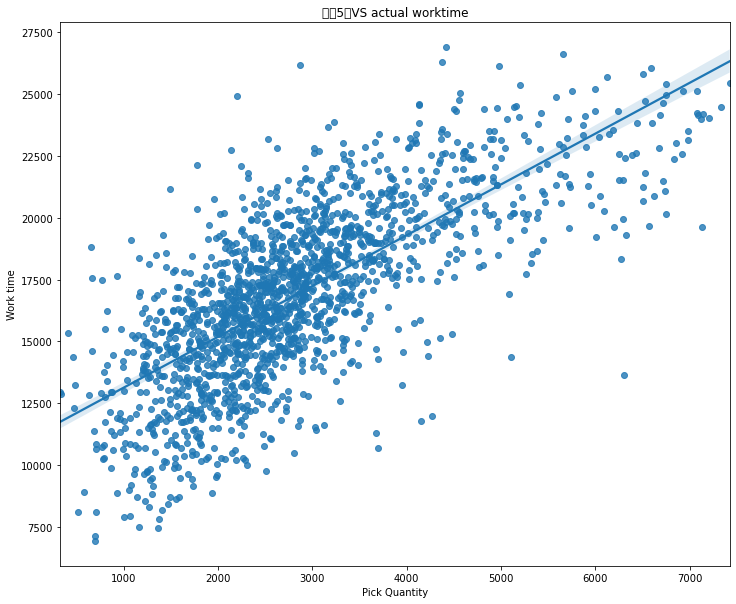

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

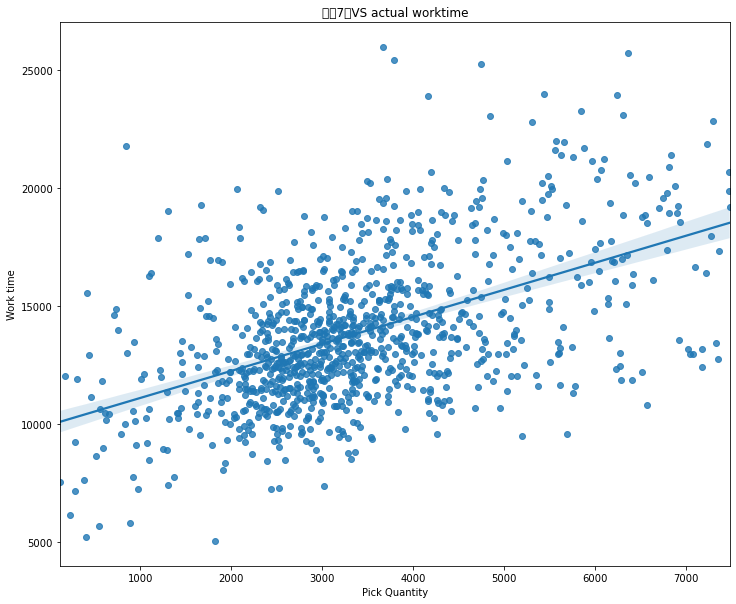

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

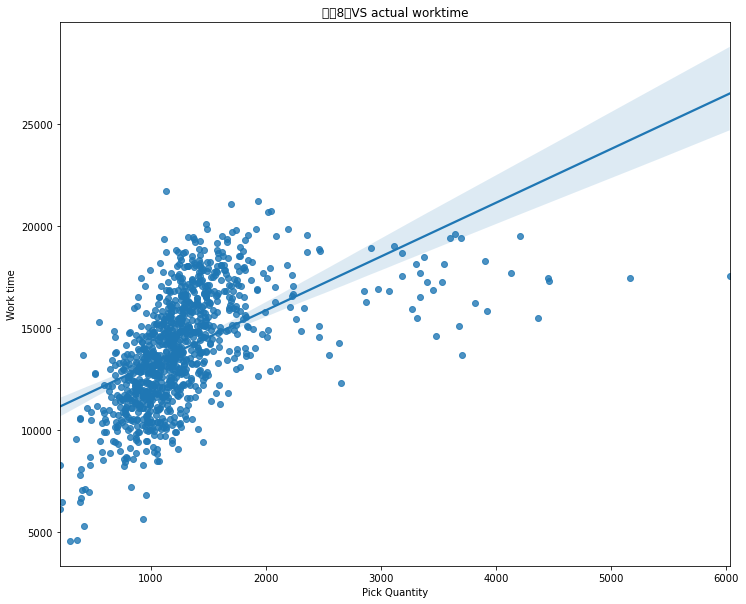

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

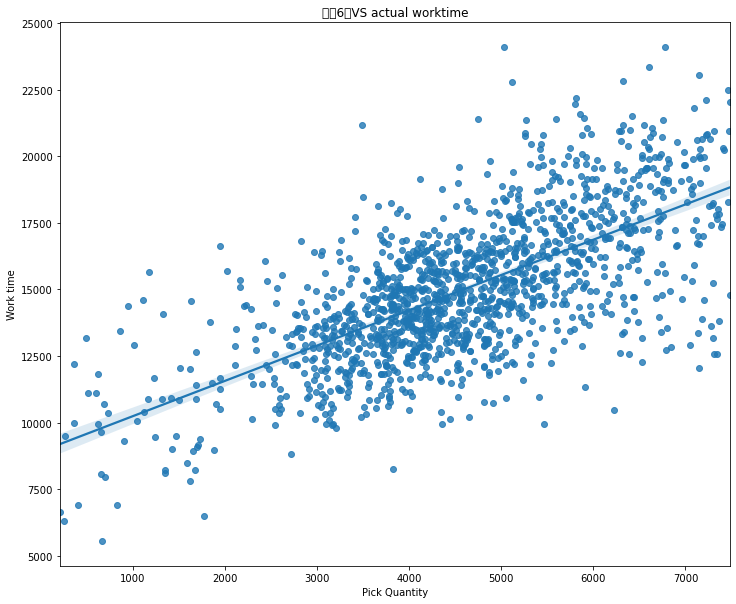

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

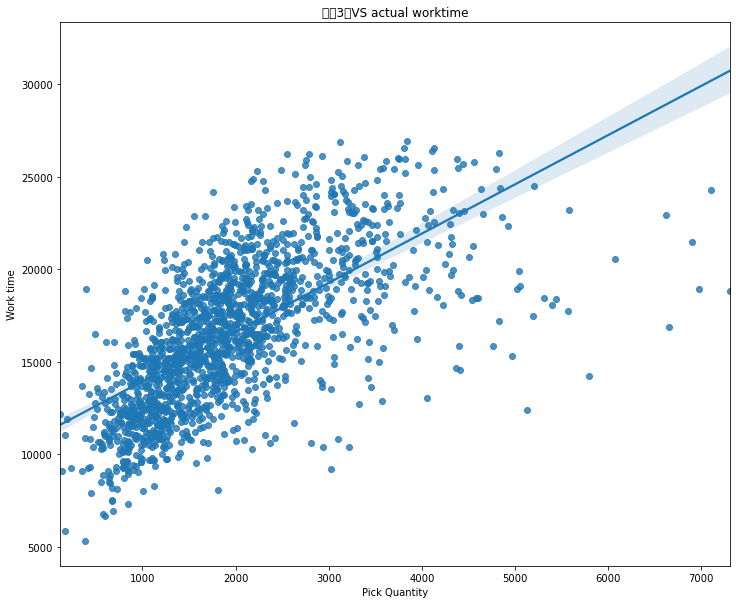

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

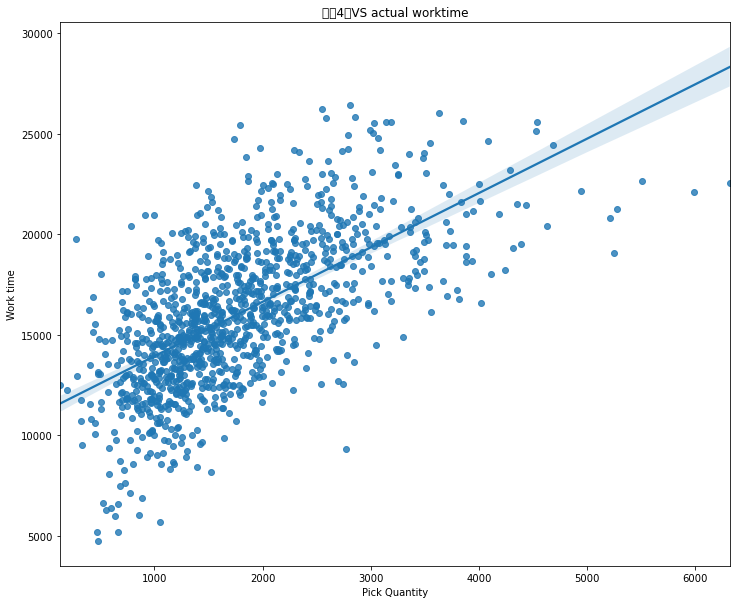

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

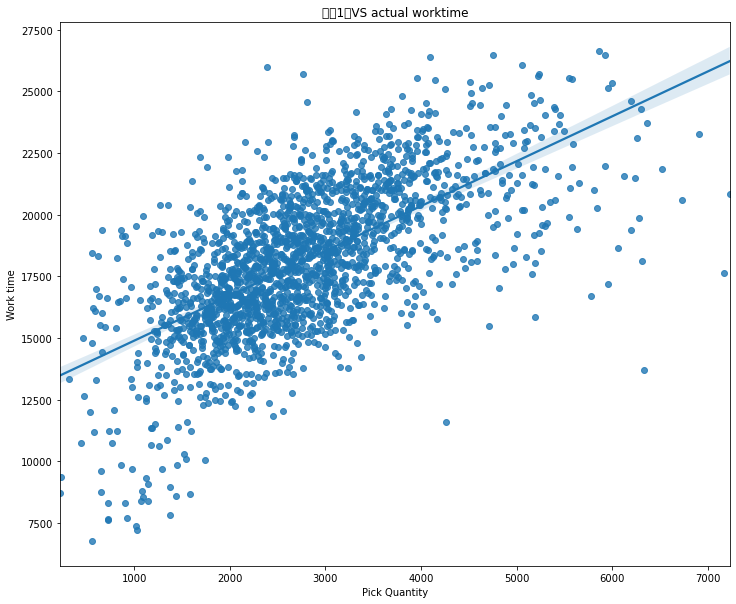

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

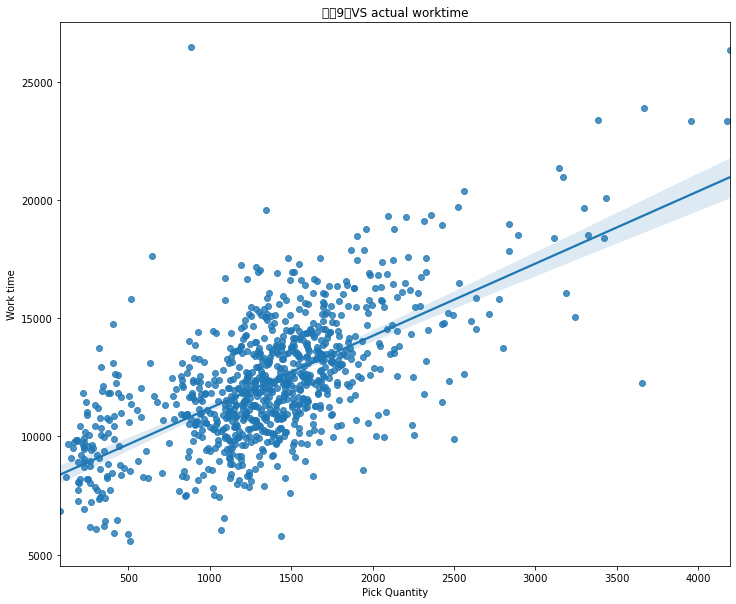

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

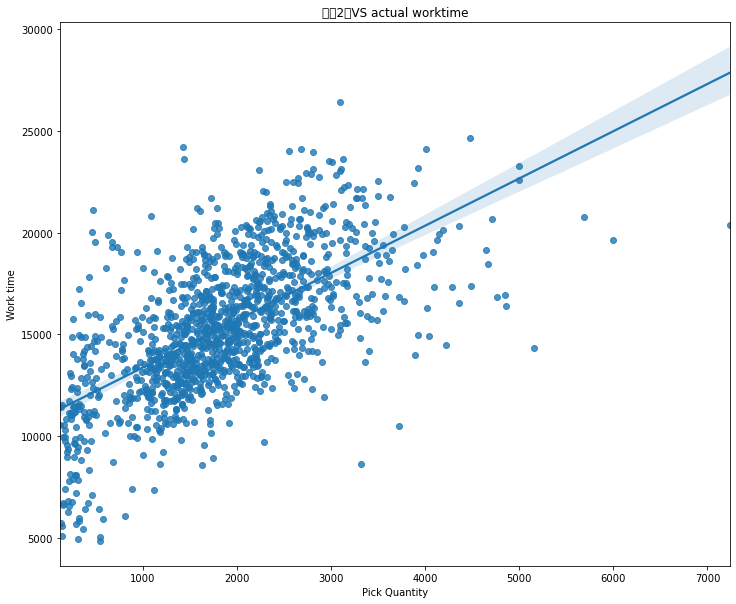

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

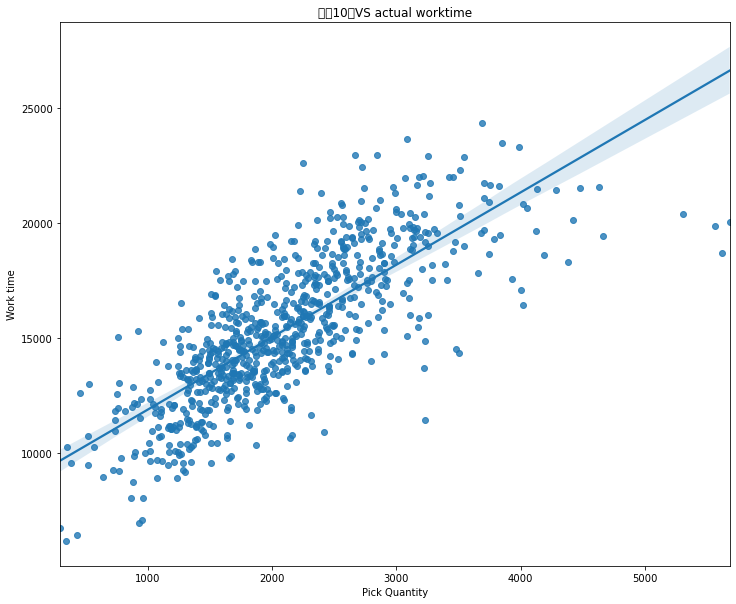

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

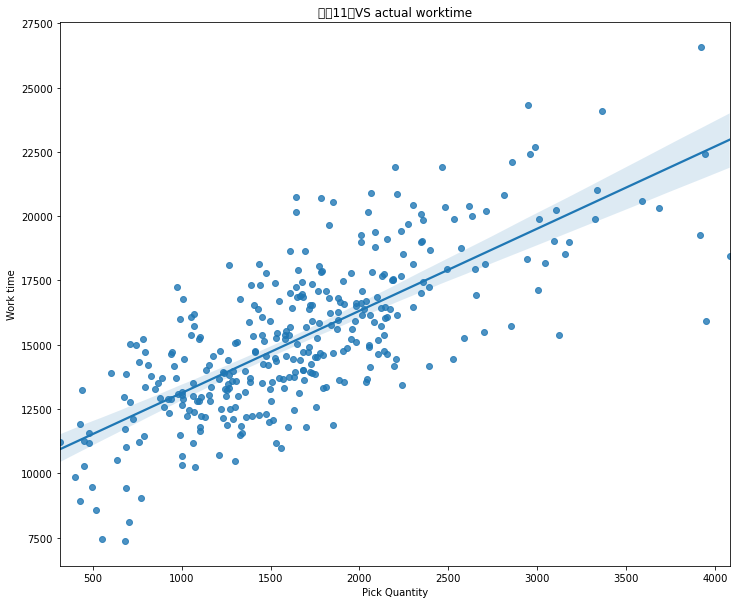

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24120 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 35268 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

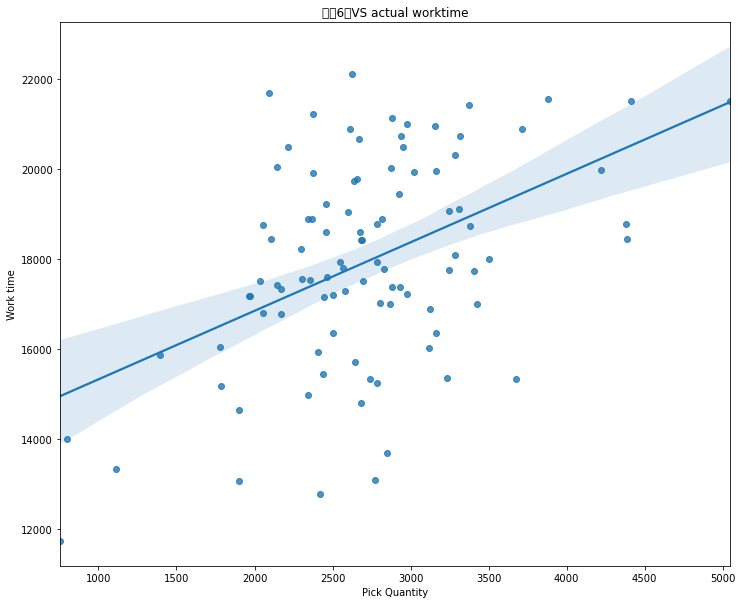

C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 32452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 40092 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\MSI\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: 

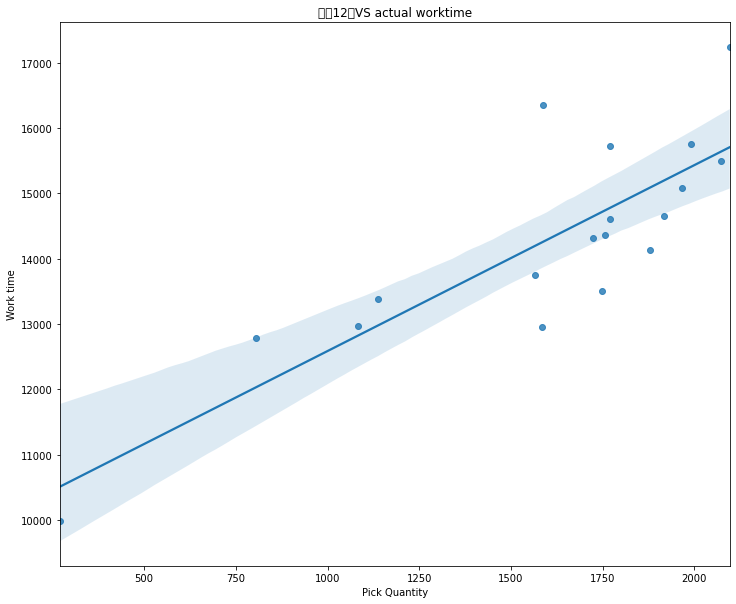

In [83]:
for shelfname in weight_wroktime_zscore['ShelfAreaName'].unique():
    shelf_df = weight_wroktime_zscore.loc[weight_wroktime_zscore.ShelfAreaName == shelfname]
    Title = shelfname +'VS actual worktime'
    graph = DistributionPlot(shelf_df, Title)